In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
from pybt.tools.plotters import *
from madxtools.plot_tool import *
import requests
from madxtools.air_scattering import *
from IPython.display import display

import xtrack as xt
import xplt
import xpart as xp
import xobjects as xo
import xcoll as xc

In [2]:
nominal_optics = [
    0.479688,
    0.21,
    0.19864,
    0.090343,
    0.195989,
    0.194437,
    0.061494,
    0.069052,
]

In [3]:
E_cin_per_nucleon = 2.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

print(p/charge)
print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p/charge,3)} GeV/c")

Brho = 3.33564*p/charge

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


In [7]:
# Matched initial parameters 13nd oct 2023
betx0 = 53.074
alfx0 = -13.191
dx0 = 0.13
dpx0 = 0.02
exn = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
dy0 = 0.0
dpy0 = 0.0
eyn = 6.94e-06

sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
print(f"ex = {ex_initial:.2e}")
ey = eyn/(beta*gamma)
ey_initial = ey
print(f"ey = {ey_initial:.2e}")

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

# Optics
optics = nominal_optics
madx.input("kQFN1 = "+str(optics[0])+";")
madx.input("kQDN2 = "+str(-optics[1])+";")
madx.input("kQFN3 = "+str(optics[2])+";")
madx.input("kQDN4 = "+str(-optics[3])+";")
madx.input("kQFN5 = "+str(optics[4])+";")
madx.input("kQDN6 = "+str(-optics[5])+";")
madx.input("kQDN7 = "+str(-optics[6])+";")
madx.input("kQFN8 = "+str(optics[7])+";")

# Add the Air region
sequence = "f61t8_op"

madx.input(f'''
beam, particle=PROTON, pc={p/charge}, exn={exn}, eyn={eyn};
use, sequence=f61t8_op;
''')

madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")


ex = 2.23e-06
ey = 6.10e-07


True

In [11]:
line_t8 = xt.Line.from_madx_sequence(
    sequence=madx.sequence.f61t8_op,
    allow_thick=True,
    enable_align_errors=True,
    deferred_expressions=True,
)

# Add air regions
# ===============
X0_air = 301
air = xc.Material(radiation_length=X0_air, name="Air (1 atm 20C)")

p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 1", at_s=p1)

# p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
# p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
# line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 2", at_s=p1)

#t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 3", at_s=p1)

p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 4", at_s=p1)

p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 5", at_s=p1)

p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 6", at_s=p1)

# pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
# len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
# pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
# line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 7", at_s=p1)

# pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
# len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
# pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
# line_t8.insert_element(element=xc.EverestBlock(length=p2-p1, material=air), name="Air 8", at_s=p1)

line_t8.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 gamm0=madx.sequence.f61t8_op.beam.gamma)
line_t8.build_tracker()

Converting sequence "f61t8_op": 100%|██████████| 114/114 [00:00<00:00, 886.50it/s]


Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [12]:
from pybt.tools.particles import *

num_part = 1000
n_sigma = 1

ctx = xo.ContextCpu()

distH = beam_distrib_norm(alfx0, betx0, ex, num_part, n_sigma)
distV = beam_distrib_norm(alfy0, bety0, ey, num_part, n_sigma)

part = xp.Particles(_context=ctx,
        mass0=xp.PROTON_MASS_EV, q0=1, p0c=24e9,
        x=distH[:, 0], px=distH[:, 1], y=distV[:, 0], py=distV[:, 1], zeta=0, delta=1e-3)
part._init_random_number_generator()

line_t8.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


ex = 2.23e-06
ey = 6.10e-07


/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/madxtools/plot_tool.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlim(0,twiss.s[-1])
/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/madxtools/plot_tool.py:168: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].set_xlim(0,twiss.s[-1])
/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/madxtools/plot_tool.py:172: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

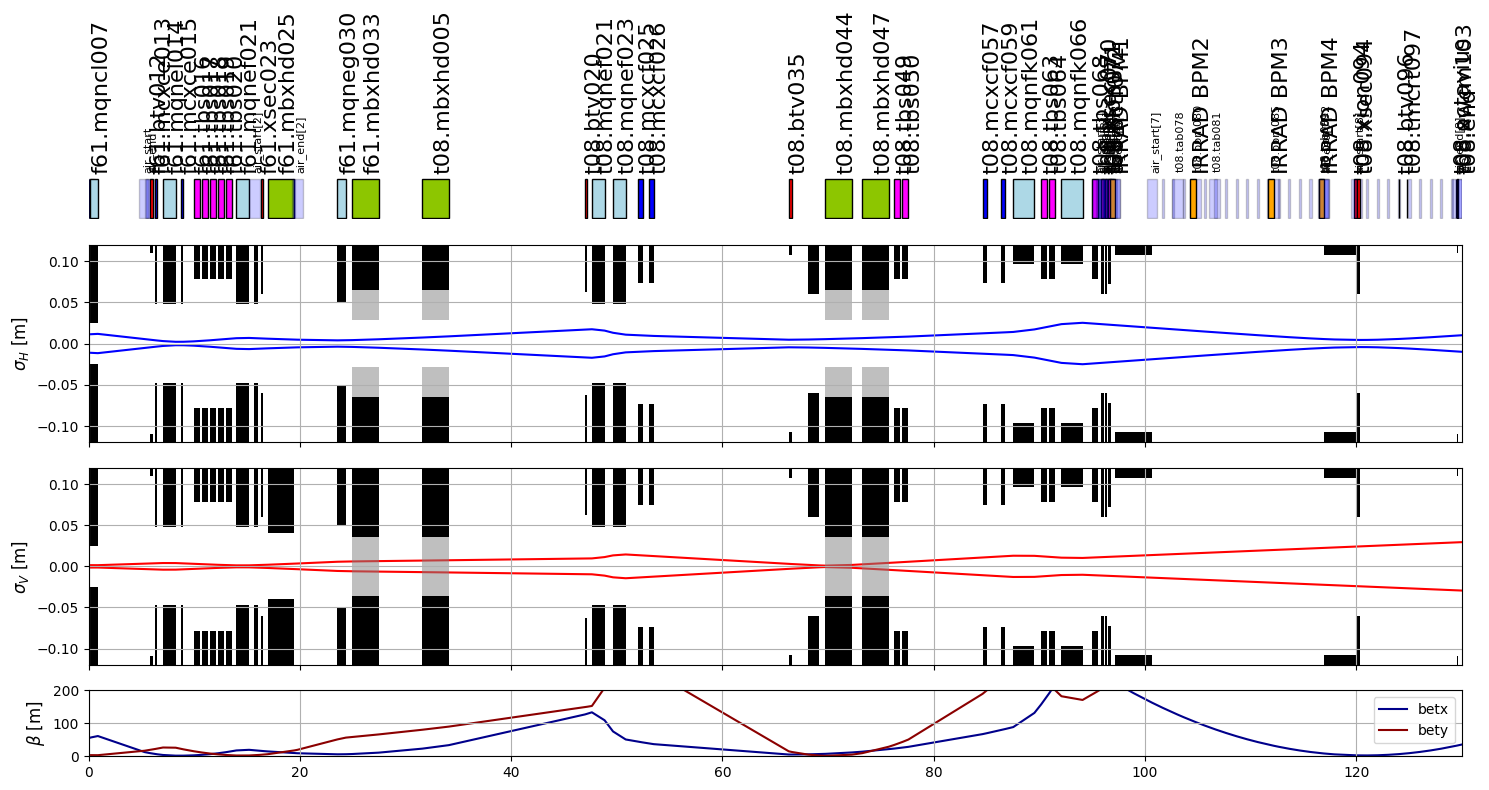

In [13]:
# Matched initial parameters 13nd oct 2023
betx0 = 53.074
alfx0 = -13.191
dx0 = 0.13
dpx0 = 0.02
exn = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
dy0 = 0.0
dpy0 = 0.0
eyn = 6.94e-06

sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
print(f"ex = {ex_initial:.2e}")
ey = eyn/(beta*gamma)
ey_initial = ey
print(f"ey = {ey_initial:.2e}")

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

# Optics
optics = nominal_optics
madx.input("kQFN1 = "+str(optics[0])+";")
madx.input("kQDN2 = "+str(-optics[1])+";")
madx.input("kQFN3 = "+str(optics[2])+";")
madx.input("kQDN4 = "+str(-optics[3])+";")
madx.input("kQFN5 = "+str(optics[4])+";")
madx.input("kQDN6 = "+str(-optics[5])+";")
madx.input("kQDN7 = "+str(-optics[6])+";")
madx.input("kQFN8 = "+str(optics[7])+";")

# Add the Air region
sequence = "f61t8_op"

p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

#t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


# add_hidden_marker(madx, sequence, 20, 100, steps)

madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)

# make thin
madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
# madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")


twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
plot_graph(twiss, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,1])


Text(0.5, 0.98, 'Tracking with xtrack  particles')

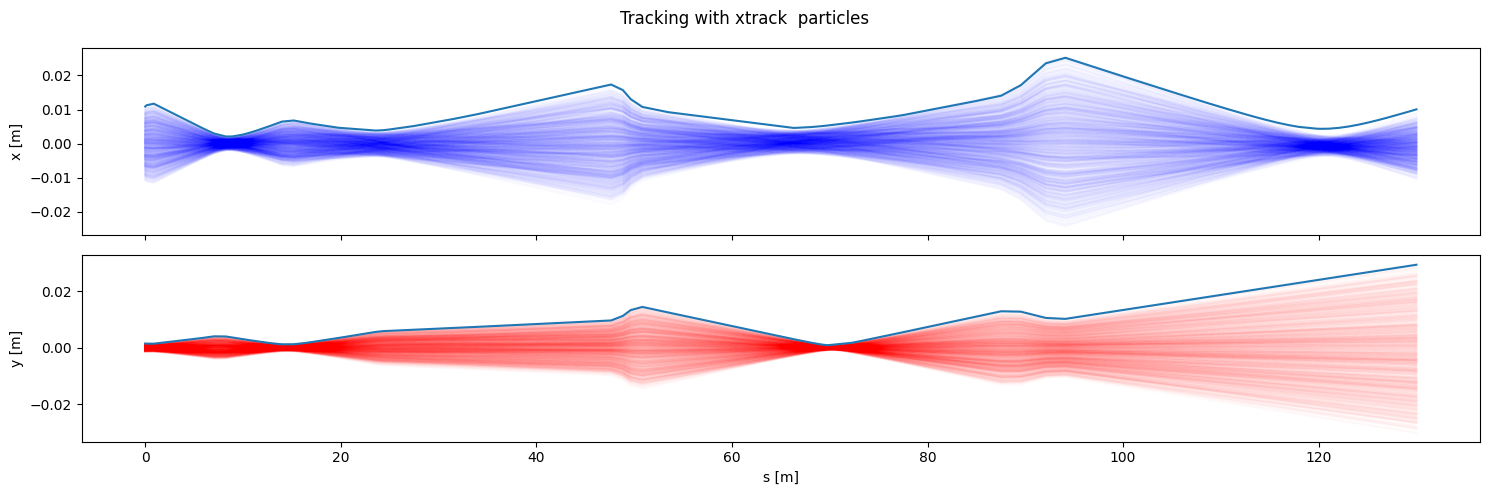

In [14]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line_t8.record_last_track.s)):
    ax[0].plot(line_t8.record_last_track.s[i], line_t8.record_last_track.x[i], color='blue', alpha=0.01);
    ax[1].plot(line_t8.record_last_track.s[i], line_t8.record_last_track.y[i], color='red', alpha=0.01);

ax[0].plot(twiss.s, beam_size(twiss['betx'], twiss['dx'], ex, sige, 1))
ax[1].plot(twiss.s, beam_size(twiss['bety'], twiss['dy'], ey, sige, 1))

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')


fig.suptitle(f'Tracking with xtrack  particles')
